Leitura do arquvio .csv, contendo os fatores de emissão.

In [65]:
import pandas as pd #Importa a biblioteca pandas as pd
import os           #Importa a biblioteca os

cwd = os.getcwd()   # cwd recebe o endereço do script

path = cwd+'\\tabelas\\FE'      #path recebe o endereço onde está o arquivo do fatores de emissão
print(path)                     #imprime o path para verificação

chapterNumer = 11
subChapter = 7
file = 'chpt_'+str(chapterNumer)+'_'+str(subChapter)+'.csv'  #file recebe path + o nome do arquivo
print(file)                       

fe = pd.read_csv(path+'\\'+file)            #fe recebe o arquivo csv
display(fe)

C:\Guilherme\ControleP\ENS410064\venv\scripts\tabelas\FE
chpt_11_7.csv


,Source,PM,SO2,NOX
0,BMP,0.0060,0.0,0.00
1,Secador,1.1500,0.0,0.00
2,Resfriador,0.0550,0.0,0.00
3,Granulacao,0.0950,0.0,0.00
4,Queima,0.2450,104.5,0.27
5,Refrigeracao,0.0335,0.0,0.00
6,Esmatacao,0.0950,0.0,0.00


Função para leitura dos fatores de emissão e estimar a emissão

In [301]:
import matplotlib.pyplot as plt
import numpy as np

def verificacao_emissao (fe, df):
    
    emissao_pm_total = np.zeros(8737)
    emissao_so2_total = np.zeros(8737)
    emissao_nox_total = np.zeros(8737)
    
    for i in range(len(fe['PM'])):
        # Multiplicar cada valor na coluna producao_diaria de df pelo valor correspondente na linha i da coluna PM de fe
        emissao_pm = df['producao_diaria'] * fe.iloc[i]['PM']
        # Adicionar emissao_pm ao DataFrame df_emissao_pm
        emissao_pm_total += emissao_pm
    for j in range(len(fe['SO2'])):
        # Multiplicar cada valor na coluna producao_diaria de df pelo valor correspondente na linha i da coluna PM de fe
        emissao_so2 = df['producao_diaria'] * fe.iloc[j]['SO2']
        emissao_so2_total += emissao_so2

    for k in range(len(fe['NOX'])):
        # Multiplicar cada valor na coluna producao_diaria de df pelo valor correspondente na linha i da coluna PM de fe
        emissao_nox = df['producao_diaria'] * fe.iloc[k]['NOX']
        emissao_nox_total += emissao_nox

    fig,ax = plt.subplots(len(fe.columns)-1,1,sharex = True, figsize = (9,15))
    for ii in range(1,len(fe.columns)): #  Este loop for itera sobre os números de 1 até o número de COLUNAS em fe (len(fe.columns)). O uso de range(1, len(fe.columns)) exclui a primeira coluna
        ax[ii-1].bar(fe['Source'],fe.iloc[:,ii],color = ['#DAF7A6','red','cyan', 'green', 'blue', 'magenta','purple'])
        ax[ii-1].set_xlabel('Processo', fontsize=12) #fontsize=8 é um argumento usado para definir o tamanho da fonte
        ax[ii-1].set_ylabel(fe.columns[ii]+'\n(kg/ton)', fontsize=12)

    return emissao_pm_total, emissao_so2_total, emissao_nox_total


Criar sazonalidade e método monte carlo para estimar a produção em 1 ano (2023)

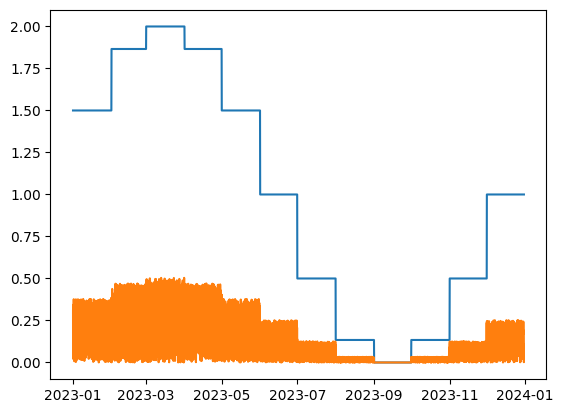

In [302]:
#criando o dataframe contendo todas as horas de 2023
i = pd.date_range(start='2023-01-01', end='2023-12-31', freq ='h') #cria um indice contendo todas as horas e dias do ano de 2023
df = pd.DataFrame(index = i) # cria um dataframe sendo que as linhas são as horas do ano

#Modelar, utilizando uma função sen, a sazonalidade nos meses do ano.

df['sazonalidade'] = (np.sin(2* np.pi * df.index.month / 12)) + 1 # somando 1 no final para não termos produção negativa 

#aplicando o método de monte carlo utilizando a biblioteca numpy

min_producao_hora = 0        #considerando que pode haver dias sem produção
max_producao_hora = 0.252083 # produção máxima possível em uma hora.

variabilidade = np.random.uniform(min_producao_hora, max_producao_hora, len(df))

df['variabilidade'] = variabilidade
df['producao_diaria'] = df['sazonalidade']*df['variabilidade']

plt.plot(df['sazonalidade'])
plt.plot(df['producao_diaria'])



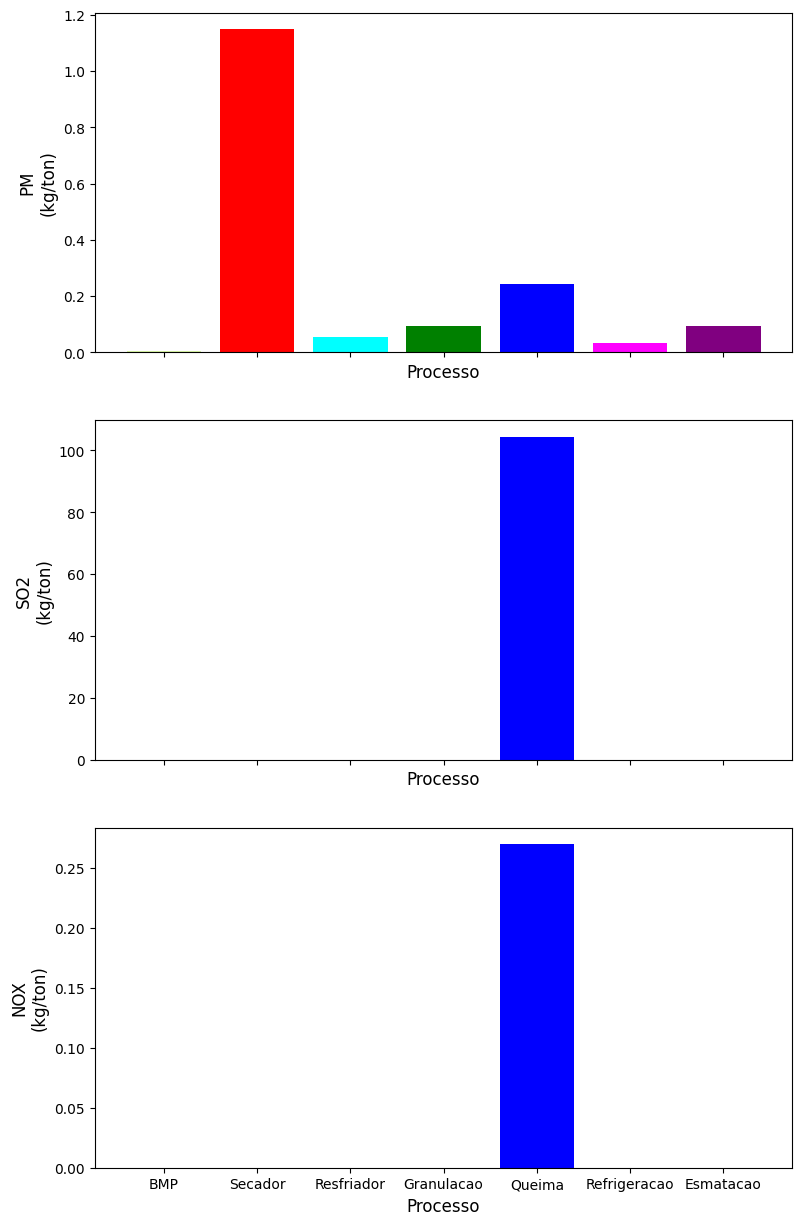

In [303]:
resultado_pm, resultado_so2, resultado_nox = verificacao_emissao(fe, df)

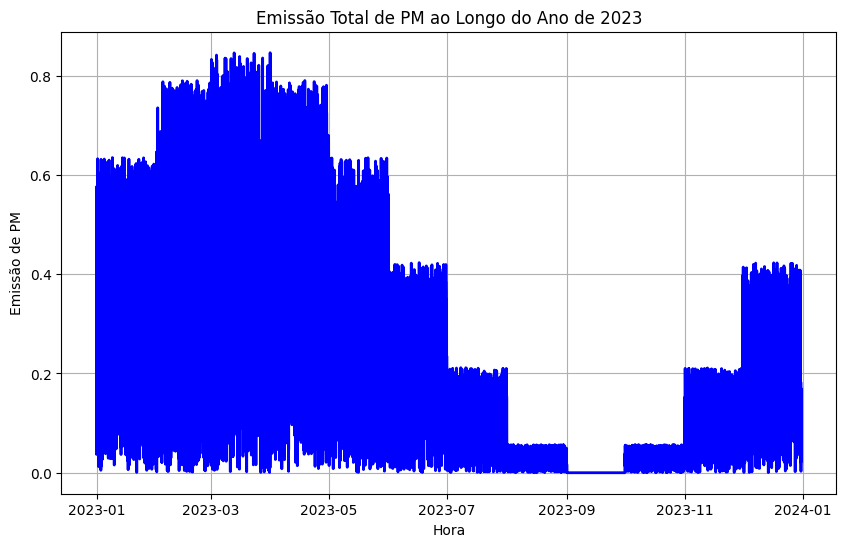

In [304]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, resultado_pm, color='blue', linewidth=2)
plt.title('Emissão Total de PM ao Longo do Ano de 2023')
plt.xlabel('Hora')
plt.ylabel('Emissão de PM')
plt.grid(True)
plt.show()

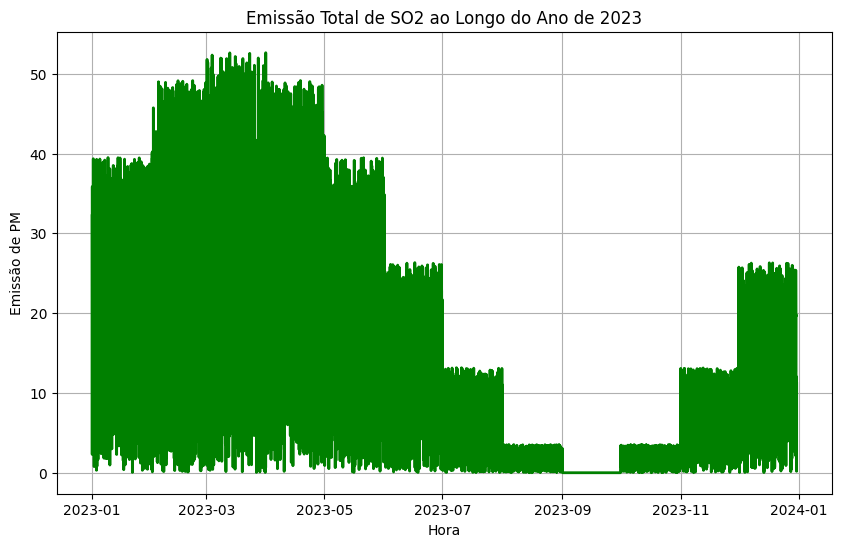

In [305]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, resultado_so2, color='green', linewidth=2)
plt.title('Emissão Total de SO2 ao Longo do Ano de 2023')
plt.xlabel('Hora')
plt.ylabel('Emissão de PM')
plt.grid(True)
plt.show()

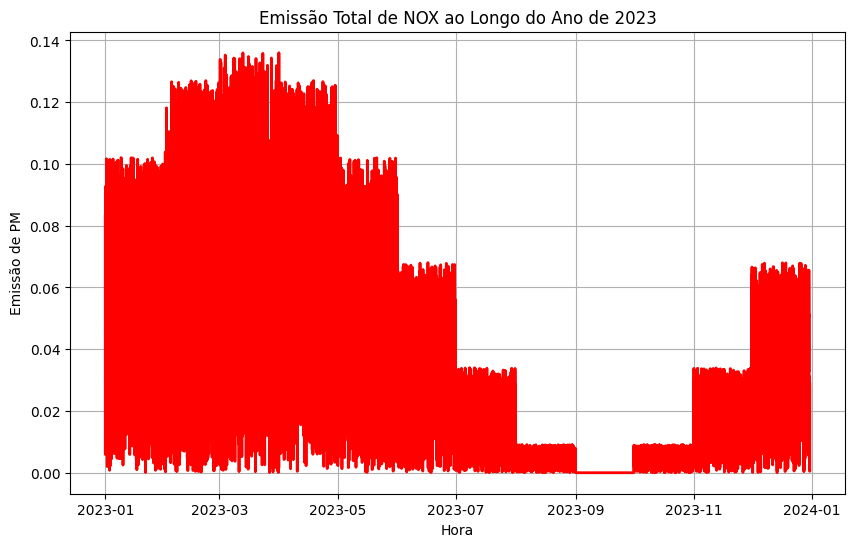

In [306]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, resultado_nox, color='red', linewidth=2)
plt.title('Emissão Total de NOX ao Longo do Ano de 2023')
plt.xlabel('Hora')
plt.ylabel('Emissão de PM')
plt.grid(True)
plt.show()

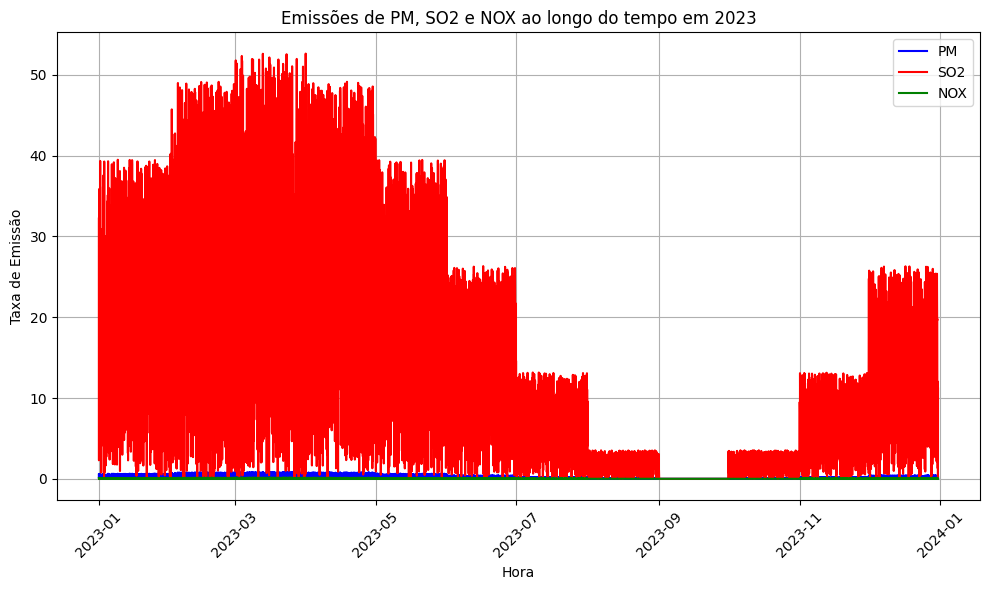

In [307]:

# Plot das emissões de PM
plt.figure(figsize=(10, 6))
plt.plot(df.index, resultado_pm, label='PM', color='blue')

# Plot das emissões de SO2
plt.plot(df.index, resultado_so2, label='SO2', color='red')

# Plot das emissões de NOX
plt.plot(df.index, resultado_nox, label='NOX', color='green')

# Personalização do gráfico
plt.title('Emissões de PM, SO2 e NOX ao longo do tempo em 2023')
plt.xlabel('Hora')
plt.ylabel('Taxa de Emissão')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar o gráfico
plt.show()


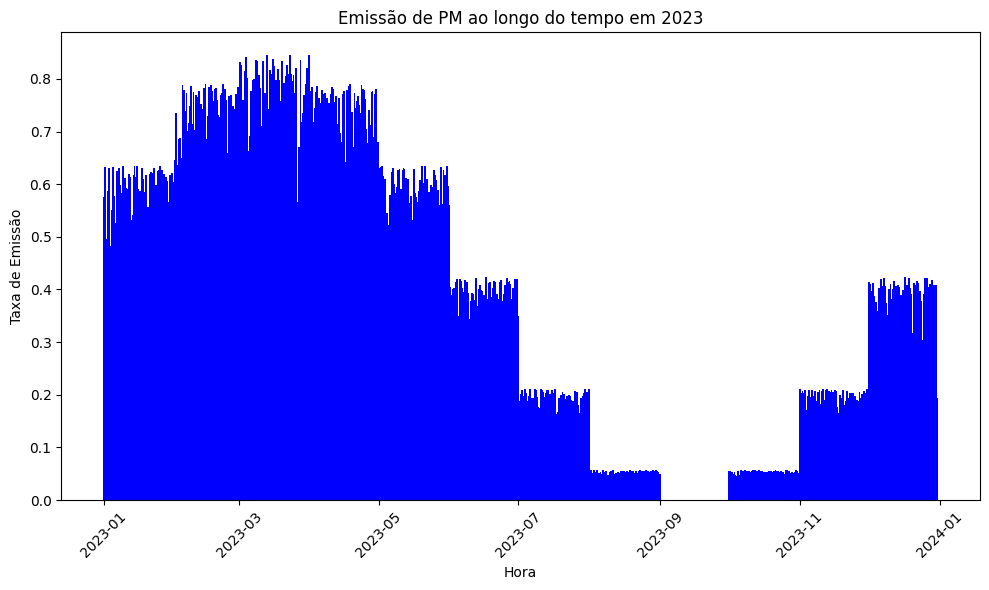

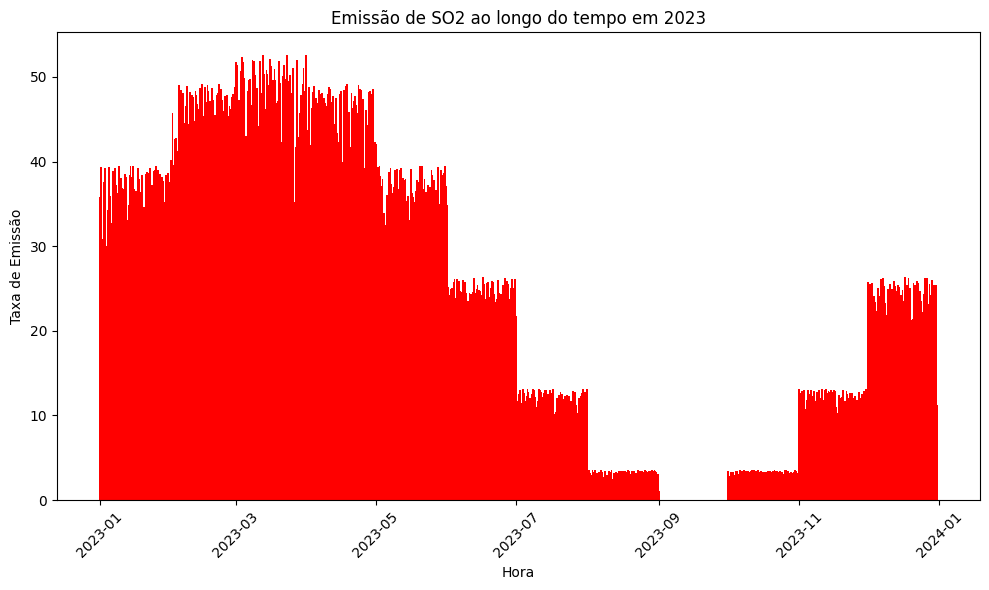

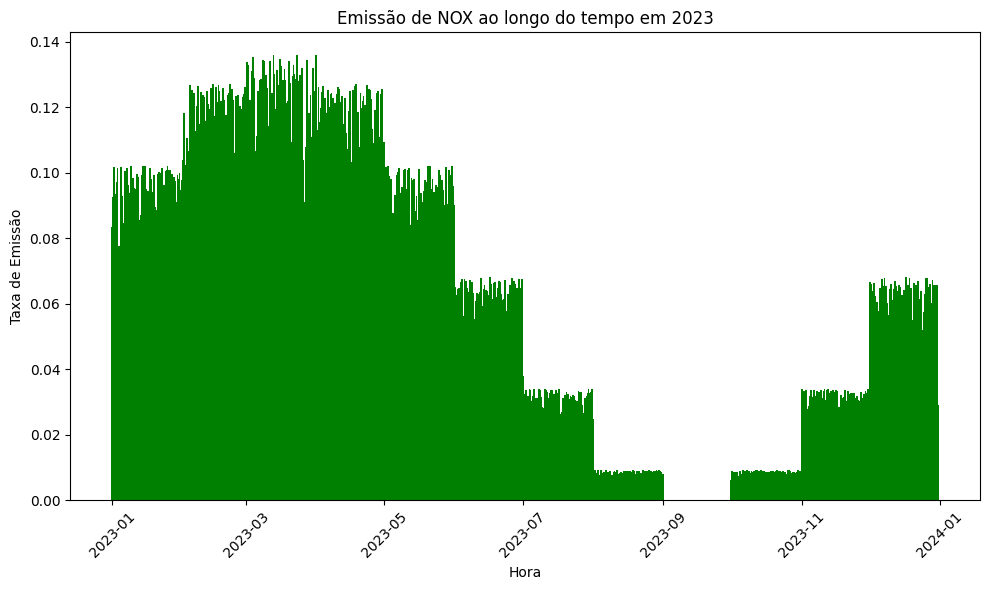

In [308]:
# Gráfico de barras para emissão de PM
plt.figure(figsize=(10, 6))
plt.bar(df.index, resultado_pm, color='blue')
plt.title('Emissão de PM ao longo do tempo em 2023')
plt.xlabel('Hora')
plt.ylabel('Taxa de Emissão')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de barras para emissão de SO2
plt.figure(figsize=(10, 6))
plt.bar(df.index, resultado_so2, color='red')
plt.title('Emissão de SO2 ao longo do tempo em 2023')
plt.xlabel('Hora')
plt.ylabel('Taxa de Emissão')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de barras para emissão de NOX
plt.figure(figsize=(10, 6))
plt.bar(df.index, resultado_nox, color='green')
plt.title('Emissão de NOX ao longo do tempo em 2023')
plt.xlabel('Hora')
plt.ylabel('Taxa de Emissão')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

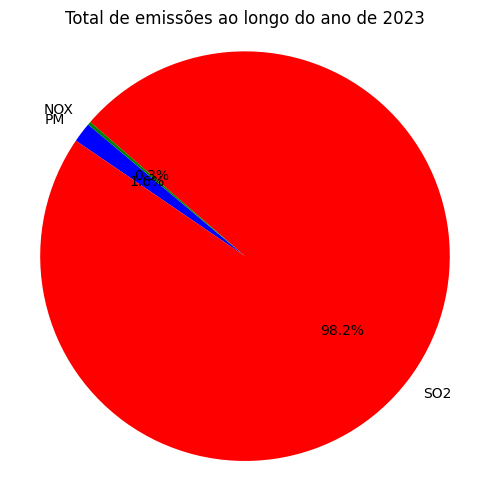

In [309]:
total_pm = sum(resultado_pm)
total_so2 = sum(resultado_so2)
total_nox = sum(resultado_nox)

# Criar um gráfico de pizza
labels = ['PM', 'SO2', 'NOX']
sizes = [total_pm, total_so2, total_nox]
colors = ['blue', 'red', 'green']
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Total de emissões ao longo do ano de 2023')
plt.axis('equal')  # Garante que o gráfico de pizza é circular
plt.tight_layout()
plt.show()